In [1]:
from google.colab import drive
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import numpy as np
from functools import reduce
from datetime import datetime, date


In [2]:
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import Sequence, load_img, img_to_array, array_to_img
from keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tensorflow as tf

In [3]:
epochs = 25
batch_size = 64
num_classes = 80
margin = 1

In [4]:
resnset50 = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
img_dir = "/content/drive/My Drive/TFG_Xarxes_neuronals_siameses/main_img/"
img_size = (178,218)

In [7]:
def visualize_pair(pair, pred=None):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
  fig.suptitle('Sim: {}'.format(pair['Sim']), size=16)
  ax1.imshow(load_img(img_dir + pair['Image1']))
  ax1.set_axis_off()
  ax2.imshow(load_img(img_dir + pair['Image2']))
  ax2.set_axis_off()
  plt.show()

In [8]:
def pairs(df):
  def f(row):
    return [[row['Image'], df[df['Class']==row['Class']].sample(n=1).iloc[0,0], 0],
            [row['Image'], df[df['Class']!=row['Class']].sample(n=1).iloc[0,0], 1]]
  return pd.DataFrame(reduce(lambda x, y: x + y, df.apply(f,axis=1).to_list(), []),
                      columns=['Image1','Image2','Sim'])

In [9]:
def get_celebrities(n_celebrities:int, refactor_class=False):
    df1, df2 = get_max_aparicions(get_identities(), n_celebrities)
    #df.reset_index(inplace=True, drop=True)
    if refactor_class:
        df1 = refactor_identity(df1, 'Identity')
    return df1, df2

def get_max_aparicions(df:pd.DataFrame, n_celebrities:int):
    aparicions_df = df["Identity"].value_counts()
    aparicions_df = aparicions_df.reset_index()
    aparicions_df = aparicions_df.rename(columns={'Identity':'aparicions', 'index':'Identity'})
    aparicions_df = aparicions_df.iloc[:n_celebrities]
    return df[df['Identity'].isin(aparicions_df['Identity'])].reset_index(drop=True), df[~df['Identity'].isin(aparicions_df['Identity'])].reset_index(drop=True)

def get_identities():
    identity_df = pd.read_csv("/content/drive/My Drive/TFG_Xarxes_neuronals_siameses/main_img/identity_CelebA.txt", sep=' ', header=None)
    identity_df = identity_df.rename(columns={0:"Image_name", 1:"Identity"})
    return identity_df

def refactor_identity(df, traget_col):
    d = get_dic_index(df, traget_col)
    df["Class"] = df.apply(lambda row: d[row[traget_col]], axis=1)
    return df

def get_dic_index(df, traget_col):
    df = df[traget_col].value_counts()
    dic_index = df.to_dict()
    i = 0
    for c in dic_index:
        dic_index[c] = i
        i += 1
    return dic_index
def get_tvt(df:pd.DataFrame, target_name:str, train_size:int):
    total_classes = df[target_name].nunique()
    n_df_col = df.shape[0]
    df = shuffle(df)
    train_df = df.iloc[:int(n_df_col*train_size)]
    val_df = df.iloc[int(n_df_col*train_size):int(n_df_col*( train_size + (1-train_size)/2 ))]
    test_df = df.iloc[int(n_df_col*( train_size + (1-train_size)/2 )):]
    while True:
        if train_df[target_name].nunique() == total_classes and val_df[target_name].nunique() == total_classes and test_df[target_name].nunique() == total_classes:
            return train_df, val_df, test_df

        df = shuffle(df)
        train_df = df.iloc[:int(n_df_col*train_size)]
        val_df = df.iloc[int(n_df_col*train_size):int(n_df_col*( train_size + (1-train_size)/2 ))]
        test_df = df.iloc[int(n_df_col*( train_size + (1-train_size)/2 )):]

In [10]:
identity_df, rest = get_celebrities(num_classes, refactor_class=True)
identity_df = identity_df[["Image_name", "Class"]].rename(columns={"Image_name": "Image"})
identity_df.head()

,Image,Class
0,000001.jpg,79
1,000096.jpg,8
2,000116.jpg,14
3,000150.jpg,9
4,000404.jpg,79


In [11]:
train_df, val_df, test_df = get_tvt(identity_df, "Class", 0.8)

In [12]:
pairsTrain = pairs(train_df)
pairsVal = pairs(val_df)
pairsTest = pairs(test_df)

In [13]:
pairsTrain.head()

,Image1,Image2,Sim
0,086366.jpg,022736.jpg,1
1,086366.jpg,021784.jpg,0
2,157091.jpg,086126.jpg,1
3,157091.jpg,027666.jpg,0
4,107363.jpg,039195.jpg,1


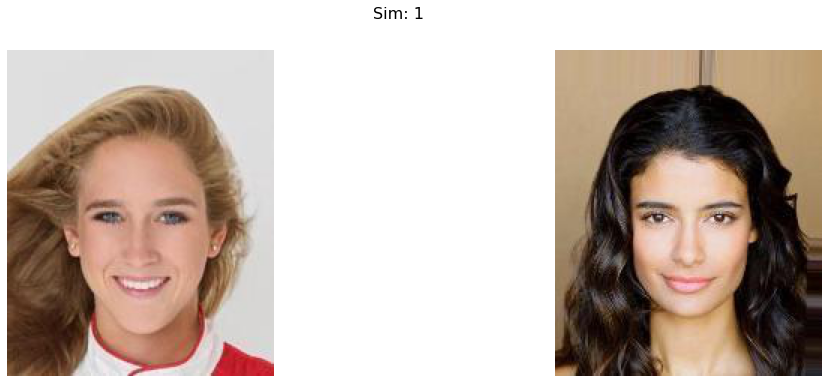

In [14]:
visualize_pair(pairsTrain.loc[0])

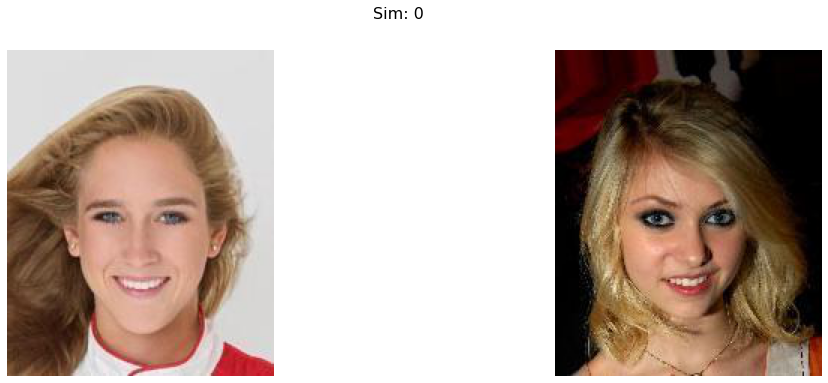

In [15]:
visualize_pair(pairsTrain.loc[1])

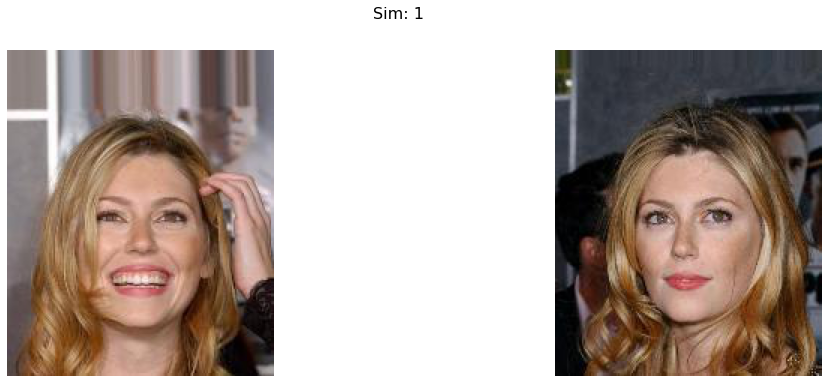

In [16]:
visualize_pair(pairsTrain.loc[pairsTrain.shape[0]-2])

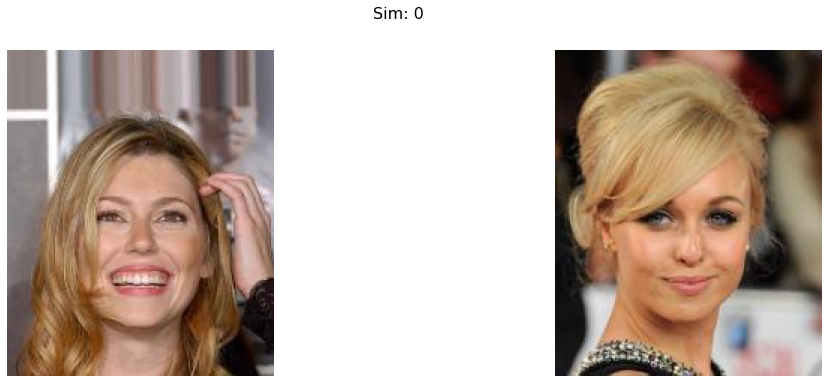

In [17]:
visualize_pair(pairsTrain.loc[pairsTrain.shape[0]-1])

In [18]:
class DataGenerator(Sequence):
  def __init__(self, df, batch_size=32, img_size=(200,200), img_dir= './', shuffle=True):
    self.batch_size = batch_size
    self.img_size = img_size
    self.img_dir = img_dir
    self.df = df
    self.indices = self.df.index.tolist()
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    return len(self.indices) // self.batch_size

  def __getitem__(self, index):
    index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
    batch = [self.indices[k] for k in index]
    
    X1, X2, y = self.__get_data(batch)
    return [X1, X2], y

  def on_epoch_end(self):
    self.index = np.arange(len(self.indices))
    if self.shuffle:
      np.random.shuffle(self.index)

  def __get_data(self, batch):
    X1 = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
    X2 = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
    y = np.zeros((self.batch_size,), dtype="float32")
    for i, idx in enumerate(batch):
      X1[i] = img_to_array(load_img(self.img_dir + self.df.loc[idx,'Image1'], target_size=self.img_size))
      X2[i] = img_to_array(load_img(self.img_dir + self.df.loc[idx,'Image2'], target_size=self.img_size))
      y[i] = self.df.loc[idx,'Sim']
    return X1, X2, y

In [19]:
trainGenerator = DataGenerator(pairsTrain, batch_size=batch_size, img_size=img_size, img_dir=img_dir)
valGenerator = DataGenerator(pairsVal, batch_size=batch_size, img_size=img_size, img_dir=img_dir)
testGenerator = DataGenerator(pairsTest, batch_size=1, img_size=img_size, img_dir=img_dir, shuffle=False)

In [20]:
class EuclideanDLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, x, y):
        sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
        return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [21]:
pretrained_base = hub.KerasLayer(resnset50, trainable = False)

In [22]:
input = layers.Input(img_size + (3,))
x = layers.Rescaling(1./255)(input)
x = pretrained_base(x)
x = layers.Flatten()(x)
embedding_network = Model(input, x)

input_1 = layers.Input(img_size + (3,))
input_2 = layers.Input(img_size + (3,))

In [23]:
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

siamese_layer = EuclideanDLayer()
siamese_layer._name = 'distance'

distance = siamese_layer(tower_1, tower_2)

# merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
features = layers.BatchNormalization()(distance)
features = layers.Dense(512, activation="relu")(features)
features = layers.Dropout(0.2)(features)
# features = layers.Dense(512, activation="relu")(features)
features = layers.Dense(256, activation="relu")(features)
features = layers.Dropout(0.2)(features)
features = layers.Dense(128, activation="relu")(features)
features = layers.Dropout(0.2)(features)
features = layers.Dense(100, activation="relu")(features)

output_layer = layers.Dense(1, activation="sigmoid")(features)

In [24]:
siamese = Model(inputs=[input_1, input_2], outputs=output_layer)

In [25]:
def loss(margin=1.0):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [26]:
siamese.compile(loss=loss(margin=margin), optimizer="adam", metrics=["accuracy"])

In [27]:
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 178, 218, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 178, 218, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 1001)         25615849    ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [28]:
callbacks = [ModelCheckpoint(f'/content/drive/My Drive/TFG_Xarxes_neuronals_siameses/Weights/{date.today()}_best.test_8',
             save_best_only=True)]

In [29]:
history = siamese.fit(trainGenerator,
                    validation_data = valGenerator,
                    callbacks=callbacks,
                    epochs=epochs,
                    batch_size=batch_size)

Epoch 1/25
60/60 [==============================] - 303s 5s/step - loss: 0.2267 - accuracy: 0.6279 - val_loss: 0.1861 - val_accuracy: 0.6875
Epoch 2/25
60/60 [==============================] - 34s 568ms/step - loss: 0.2268 - accuracy: 0.6294 - val_loss: 0.1784 - val_accuracy: 0.7210
Epoch 3/25
60/60 [==============================] - 25s 413ms/step - loss: 0.2264 - accuracy: 0.6302 - val_loss: 0.1836 - val_accuracy: 0.7143
Epoch 4/25
60/60 [==============================] - 23s 380ms/step - loss: 0.2269 - accuracy: 0.6310 - val_loss: 0.1843 - val_accuracy: 0.7232
Epoch 5/25
60/60 [==============================] - 23s 378ms/step - loss: 0.2252 - accuracy: 0.6281 - val_loss: 0.1800 - val_accuracy: 0.7254
Epoch 6/25
60/60 [==============================] - 24s 390ms/step - loss: 0.2264 - accuracy: 0.6273 - val_loss: 0.1836 - val_accuracy: 0.7388
Epoch 7/25
60/60 [==============================] - 23s 376ms/step - loss: 0.2256 - accuracy: 0.6326 - val_loss: 0.1875 - val_accuracy: 0.7299
E

In [30]:
siamese.evaluate(testGenerator)

488/488 [==============================] - 37s 73ms/step - loss: 0.1913 - accuracy: 0.6783


[0.1912812739610672, 0.6782786846160889]

In [31]:
siamese.save(f'/content/drive/My Drive/TFG_Xarxes_neuronals_siameses/models/{date.today()}Final.test_8')

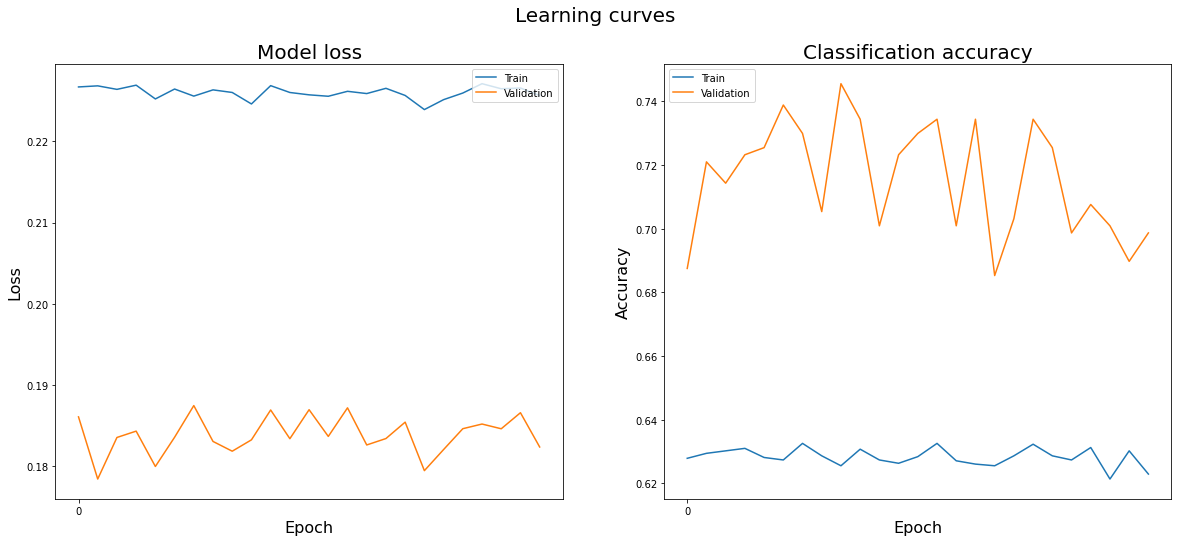

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (20, 8))

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Model loss', size=20)
ax1.set_ylabel('Loss', size=16)
ax1.set_xlabel('Epoch', size=16)
ax1.set_xticks(range(0, 6, 25))
ax1.legend(['Train', 'Validation'], loc='upper right')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('Classification accuracy', size=20)
ax2.set_ylabel('Accuracy', size=16)
ax2.set_xlabel('Epoch', size=16)
ax2.set_xticks(range(0, 6, 25))
ax2.legend(['Train', 'Validation'], loc='upper left')

fig.suptitle('Learning curves', size=20)

plt.show()

In [33]:
pairsTest['Preds'] = siamese.predict(testGenerator)

488/488 [==============================] - 12s 23ms/step


In [34]:
pairsTest.to_csv(f'/content/drive/My Drive/TFG_Xarxes_neuronals_siameses/{date.today()} Preds_test_8.txt')

In [35]:
from sklearn.metrics import r2_score, mean_absolute_error

In [36]:
r2_score(pairsTest['Sim'], pairsTest['Preds'])

0.23487425918293092

In [37]:
mean_absolute_error(pairsTest['Sim'], pairsTest['Preds'])

0.38529666384956873

In [72]:
def visualize(pair, to_show=2):
  for i in range(to_show*2):
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
      fig.suptitle('Sim: {}\nPred: {}'.format(pair['Sim'].loc[i], pair['Preds'].loc[i]), size=16)
      ax1.imshow(load_img(img_dir + pair['Image1'].loc[i]))
      ax1.set_axis_off()
      ax2.imshow(load_img(img_dir + pair['Image2'].loc[i]))
      ax2.set_axis_off()
  plt.show()

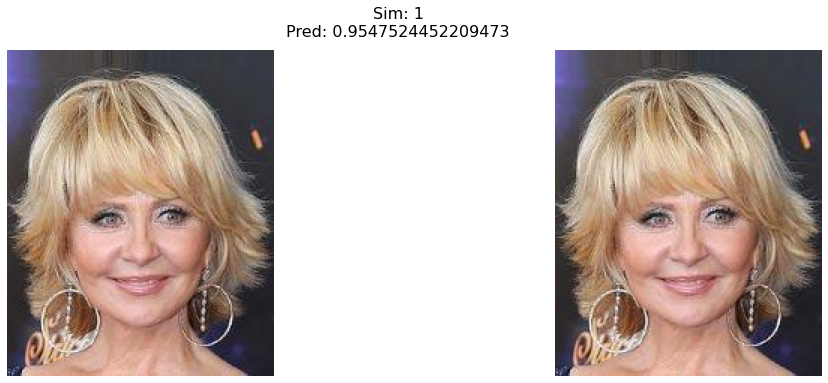

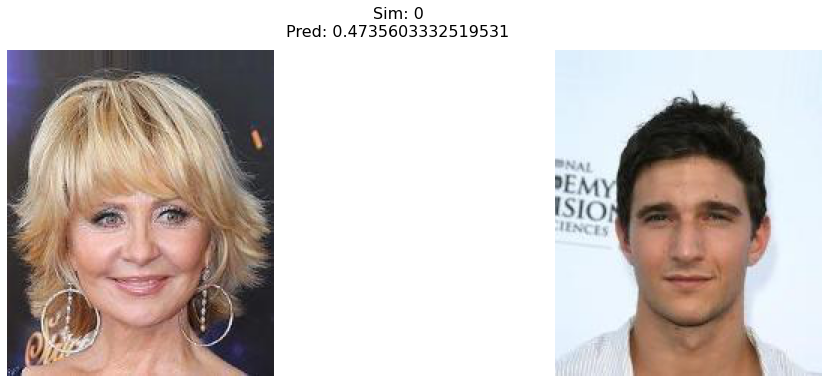

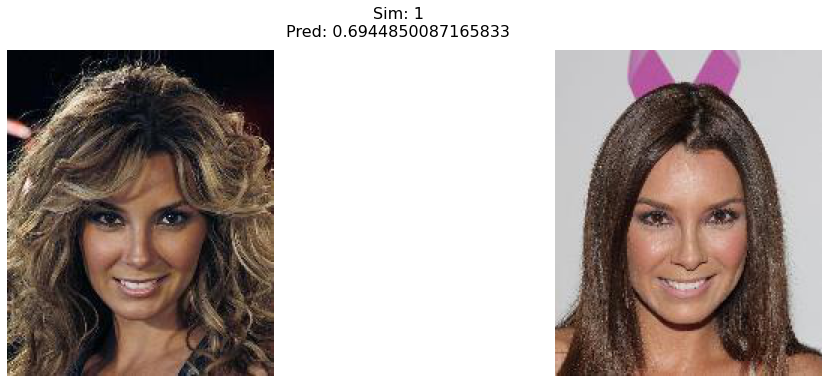

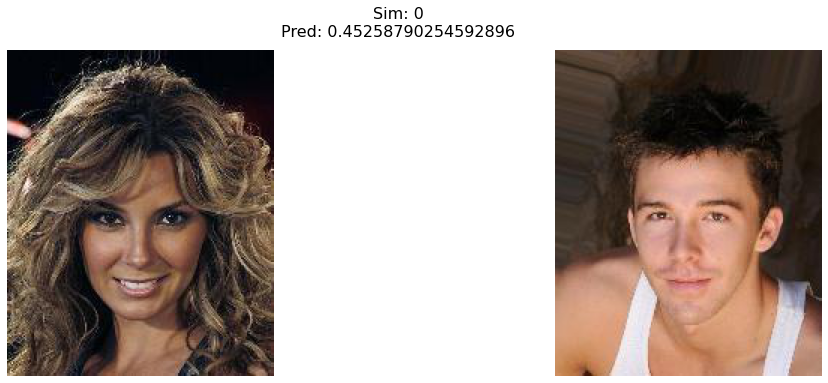

In [74]:
visualize(pairsTest)